In [1]:
from pathlib import Path
import torch

# Update this path to point at your checkpoint directory
checkpoint_dir = Path("/carnegie/nobackup/users/lvulpius/ESCHER-Swarm-Solver/ESCHER-Torch/results/swarm_defense/2025_11_16_04_12_45/")
metadata_path = checkpoint_dir / "metadata.pt"
policy_path = checkpoint_dir / "policy.pt"

metadata = torch.load(metadata_path, map_location="cpu")
policy_state_dict = torch.load(policy_path, map_location="cpu")

metadata


{'timestamp': '2025_11_16_04_12_45',
 'num_iterations': 3,
 'num_traversals': 60,
 'num_val_traversals': 20,
 'num_workers': 1,
 'batch_size_regret': 128,
 'batch_size_value': 96,
 'batch_size_policy': 128,
 'train_steps': 250,
 'total_nodes': 6797,
 'total_time_seconds': 88.20833444595337,
 'final_exploitability': None,
 'device': 'cuda',
 'num_cpu_threads': 1,
 'test_mode': True,
 'config_file': '../ESCHER-Torch/configs/swarm_example.yaml',
 'training_overrides': {'num_iterations': 3,
  'num_traversals': 60,
  'num_val_traversals': 20,
  'num_workers': 1,
  'batch_size_regret': 128,
  'batch_size_value': 96,
  'batch_size_policy': 128,
  'train_steps': 250},
 'game_config': {'parameters': {'grid_rows': 8,
   'grid_cols': 6,
   'num_targets': 2,
   'num_ad_units': 2,
   'num_attacking_drones': 4,
   'num_interceptors': 2,
   'ad_kill_probability': 0.8,
   'interceptor_reward': 1.5},
  'requested_parameters': {'grid_rows': 8,
   'grid_cols': 6,
   'num_targets': 2,
   'num_ad_units': 2

In [2]:
# Inspect policy weights; load into your model definition as needed
list(policy_state_dict.keys())


['net.0.weight',
 'net.0.bias',
 'net.2.weight',
 'net.2.bias',
 'net.4.weight',
 'net.4.bias',
 'out.weight',
 'out.bias']

In [3]:
from pathlib import Path
import importlib
import importlib.util
import sys
import pyspiel

# Derive repo root from the checkpoint path
repo_root = checkpoint_dir.resolve().parents[3]
reset_game_path = repo_root / 'Swarm-AD-OpenSpielReset' / 'swarm_defense_game.py'

# Verify we're loading the Reset version
print(f"Loading game from: {reset_game_path}")
if not reset_game_path.exists():
    raise FileNotFoundError(f"Game file not found at {reset_game_path}")

# Load/reload the module properly by adding it to sys.modules first
# If module was already loaded, reload it to pick up any code changes
module_name = 'swarm_defense_game'
if module_name in sys.modules:
    print(f"Reloading module {module_name} to pick up code changes...")
    importlib.reload(sys.modules[module_name])
    module = sys.modules[module_name]
else:
    spec = importlib.util.spec_from_file_location(module_name, reset_game_path)
    module = importlib.util.module_from_spec(spec)
    # Add to sys.modules before execution so dataclasses can resolve properly
    sys.modules[module_name] = module
    spec.loader.exec_module(module)

# Format game parameters as a spec string (e.g., "swarm_defense(grid_rows=18,grid_cols=18,...)")
game_params = metadata.get('game_config', {}).get('parameters', {}) or {}
if game_params:
    # Format as spec string: "swarm_defense(param1=value1,param2=value2,...)"
    param_parts = [f"{key}={value}" for key, value in game_params.items()]
    spec_string = f"swarm_defense({','.join(param_parts)})"
    print(f"Loading game with spec: {spec_string}")
    game = pyspiel.load_game(spec_string)
else:
    print("Loading game with default parameters")
    game = pyspiel.load_game('swarm_defense')

print(f"✓ Game loaded successfully!")
game


Loading game from: /carnegie/nobackup/users/lvulpius/ESCHER-Swarm-Solver/Swarm-AD-OpenSpielReset/swarm_defense_game.py
Loading game with spec: swarm_defense(grid_rows=8,grid_cols=6,num_targets=2,num_ad_units=2,num_attacking_drones=4,num_interceptors=2,ad_kill_probability=0.8,interceptor_reward=1.5)
✓ Game loaded successfully!


swarm_defense(ad_kill_probability=0.8,grid_cols=6,grid_rows=8,interceptor_reward=1.5,num_ad_units=2,num_attacking_drones=4,num_interceptors=2,num_targets=2)

In [4]:
import numpy as np
import sys
from pathlib import Path

# Add ESCHER-Torch directory to Python path
# The notebook is in ESCHER-Torch/notebooks/, so ESCHER_Torch module is at ../ESCHER_Torch/
notebook_dir = Path.cwd()  # Current working directory (where notebook is)
escher_torch_dir = notebook_dir.parent  # ESCHER-Torch directory
if str(escher_torch_dir) not in sys.path:
    sys.path.insert(0, str(escher_torch_dir))
    print(f"Added to Python path: {escher_torch_dir}")

from ESCHER_Torch.eschersolver import PolicyNetwork

# Get game dimensions
initial_state = game.new_initial_state()
state_tensor_size = len(initial_state.information_state_tensor(0))
num_actions = game.num_distinct_actions()

print(f"\nGame dimensions:")
print(f"  State tensor size: {state_tensor_size}")
print(f"  Number of actions: {num_actions}")

# Create policy network with standard architecture (256, 128)
# This matches the typical ESCHER training configuration
hidden_layers = (256, 128)
policy_net = PolicyNetwork(
    input_size=state_tensor_size,
    hidden_layers=hidden_layers,
    num_actions=num_actions
)

# Load the policy weights
policy_net.load_state_dict(policy_state_dict)
policy_net.eval()

print(f"\n✓ Policy network loaded successfully!")
print(f"  Architecture: {state_tensor_size} -> {hidden_layers} -> {num_actions}")

policy_net


Added to Python path: /carnegie/nobackup/users/lvulpius/ESCHER-Swarm-Solver/ESCHER-Torch
Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'

Game dimensions:
  State tensor size: 47
  Number of actions: 99

✓ Policy network loaded successfully!
  Architecture: 47 -> (256, 128) -> 99


PolicyNetwork(
  (net): Sequential(
    (0): Linear(in_features=47, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (out): Linear(in_features=128, out_features=99, bias=True)
)

### Visualizing policy network

In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Create a new state with fixed targets and first AD
state_base = game.new_initial_state()

print("=== Setting Fixed Target Positions ===")
num_targets = game.config.num_targets

# Set fixed target positions
target_actions = []
desired_second_target_pos = (3, 5)  # Row 3, Column 5

# First, check if (3, 5) is a valid candidate cell
target_cells = game.config.get_target_candidate_cells()
if desired_second_target_pos not in target_cells:
    print(f"  Warning: Position {desired_second_target_pos} is not a valid target candidate cell")
    print(f"  Valid target cells: rows {game.config.bottom_half_start + 1} to {game.config.grid_rows - 1}, cols 1 to {game.config.grid_cols - 2}")
    print(f"  Available candidate cells: {target_cells[:10]}..." if len(target_cells) > 10 else f"  Available candidate cells: {target_cells}")

for i in range(num_targets):
    if state_base.current_player() == pyspiel.PlayerId.CHANCE:
        chance_outcomes = state_base.chance_outcomes()
        legal_actions = [a for (a, _) in chance_outcomes]
        if len(legal_actions) > 0:
            if i == 1:  # Second target - set to (3, 5)
                # Find the action that places target at (3, 5) by decoding each legal action
                action_found = None
                for action in legal_actions:
                    try:
                        decoded_pos = state_base._decode_target_position_action(action)
                        if decoded_pos == desired_second_target_pos:
                            action_found = action
                            break
                    except:
                        continue
                
                if action_found is not None:
                    state_base.apply_action(action_found)
                    target_actions.append(action_found)
                    print(f"  Target {i+1} position set to {desired_second_target_pos} (action {action_found})")
                else:
                    print(f"  Warning: Could not find action for position {desired_second_target_pos} in legal actions")
                    # Show what positions are available
                    available_positions = []
                    for action in legal_actions[:5]:  # Show first 5
                        try:
                            pos = state_base._decode_target_position_action(action)
                            available_positions.append(pos)
                        except:
                            pass
                    print(f"  Available positions (first 5): {available_positions}")
                    # Fallback to first legal action
                    action = legal_actions[0]
                    decoded_pos = state_base._decode_target_position_action(action)
                    state_base.apply_action(action)
                    target_actions.append(action)
                    print(f"  Target {i+1} position set to {decoded_pos} (action {action})")
            else:
                # For first target, use first legal action
                action = legal_actions[0]
                decoded_pos = state_base._decode_target_position_action(action)
                state_base.apply_action(action)
                target_actions.append(action)
                print(f"  Target {i+1} position set to {decoded_pos} (action {action})")

print(f"\n=== Setting Fixed Target Values ===")
if state_base.current_player() == pyspiel.PlayerId.CHANCE and state_base.phase().name == "TARGET_VALUES":
    chance_outcomes = state_base.chance_outcomes()
    if len(chance_outcomes) > 0:
        # Use first value permutation (you can change this)
        action = chance_outcomes[0][0]
        state_base.apply_action(action)
        print(f"  Target values set (action {action})")

print(f"\n=== Setting Fixed First AD Location ===")
if state_base.current_player() == 1 and state_base.phase().name == "AD_PLACEMENT":
    legal_actions = state_base.legal_actions(1)
    if len(legal_actions) > 0:
        # Use first legal AD action for first AD
        first_ad_action = legal_actions[0]
        state_base.apply_action(first_ad_action)
        print(f"  First AD placed at action {first_ad_action}")
        
        # Decode the position to show where it is
        if hasattr(state_base, '_decode_ad_position'):
            row, col = state_base._decode_ad_position(first_ad_action)
            print(f"  First AD position: row={row}, col={col}")
    else:
        print("  No legal AD actions available")

print(f"\nBase state phase: {state_base.phase()}")
print(f"Base state player: {state_base.current_player()}")

# Show what we have so far
if hasattr(state_base, '_targets') and len(state_base._targets) > 0:
    print(f"\nTargets set: {[(t.row, t.col, t.value) for t in state_base._targets]}")
if hasattr(state_base, '_ad_units') and len(state_base._ad_units) > 0:
    print(f"AD units set: {[(u.row, u.col) for u in state_base._ad_units]}")

state_base


=== Setting Fixed Target Positions ===
  Valid target cells: rows 5 to 7, cols 1 to 4
  Available candidate cells: [(5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2)]...
  Target 1 position set to (5, 1) (action 0)
  Available positions (first 5): [(5, 2), (5, 3), (5, 4), (6, 1), (6, 2)]
  Target 2 position set to (5, 2) (action 1)

=== Setting Fixed Target Values ===
  Target values set (action 12)

=== Setting Fixed First AD Location ===
  First AD placed at action 14
  First AD position: row=4, col=0

Base state phase: Phase.AD_PLACEMENT
Base state player: 1

Targets set: [(5, 1, 10.0), (5, 2, 20.0)]
AD units set: [(4, 0)]


Phase: AD_PLACEMENT
Targets:
  T0: (5,1) value=10.0
  T1: (5,2) value=20.0
AD units:
  AD0: (4,0) alive
Drone assignments:
Returns: [0.0, 0.0]

=== Evaluating Second AD Locations ===
Available second AD positions: 5

Evaluating 5 second AD locations...
  Progress: 0/5

✓ Evaluated 5 second AD locations

=== Top 10 Second AD Locations (by Max Policy Probability) ===
1. Position ( 4,  2): max_prob=0.0684, mean_prob=0.0139, entropy=3.6773, legal_actions=72
2. Position ( 4,  4): max_prob=0.0677, mean_prob=0.0139, entropy=3.6763, legal_actions=72
3. Position ( 6,  4): max_prob=0.0644, mean_prob=0.0139, entropy=3.6977, legal_actions=72
4. Position ( 6,  2): max_prob=0.0642, mean_prob=0.0139, entropy=3.7112, legal_actions=72
5. Position ( 6,  0): max_prob=0.0593, mean_prob=0.0139, entropy=3.7761, legal_actions=72


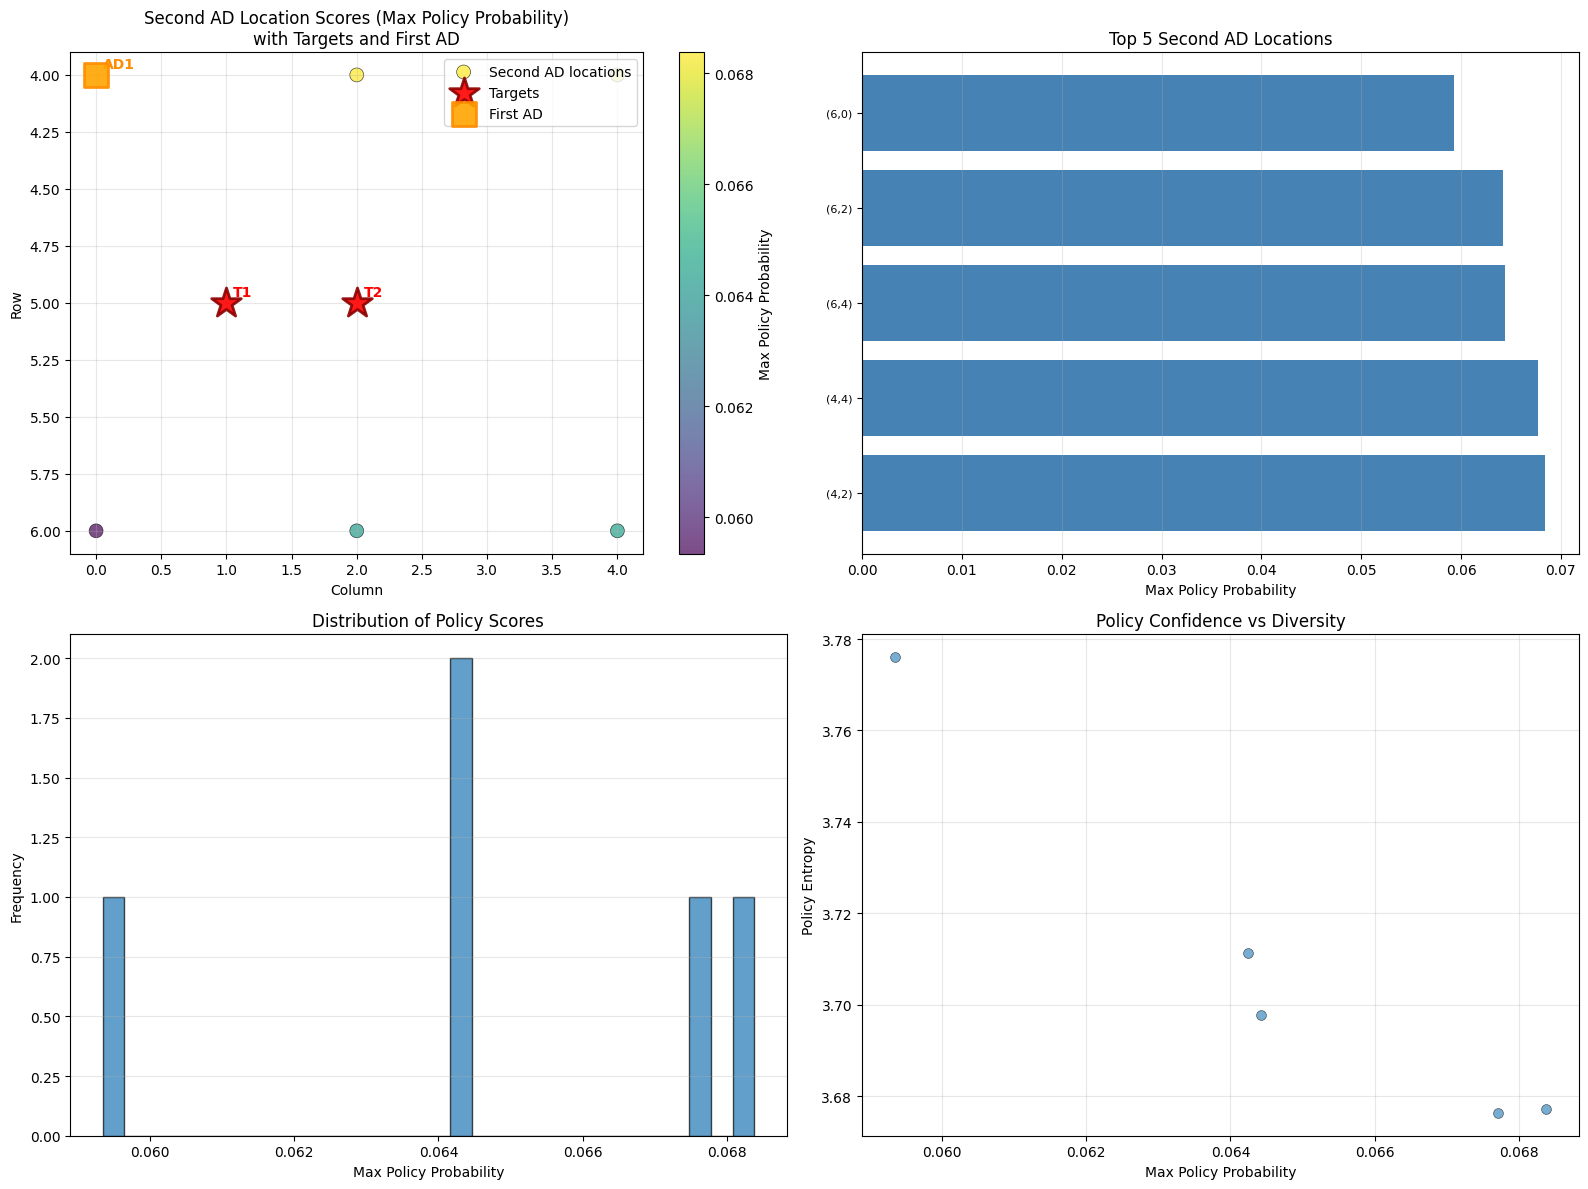


✓ Results stored in 'results' variable
  Best location: (4, 2) with score 0.0684


[{'action': 15,
  'row': 4,
  'col': 2,
  'max_prob': 0.06837784498929977,
  'mean_prob': 0.013888890855014324,
  'entropy': 3.6772613525390625,
  'num_legal_actions': 72,
  'phase': 'SWARM_ASSIGNMENT',
  'player': 0},
 {'action': 16,
  'row': 4,
  'col': 4,
  'max_prob': 0.06771259009838104,
  'mean_prob': 0.013888890855014324,
  'entropy': 3.676309823989868,
  'num_legal_actions': 72,
  'phase': 'SWARM_ASSIGNMENT',
  'player': 0},
 {'action': 17,
  'row': 6,
  'col': 0,
  'max_prob': 0.05934461951255798,
  'mean_prob': 0.013888888992369175,
  'entropy': 3.776064395904541,
  'num_legal_actions': 72,
  'phase': 'SWARM_ASSIGNMENT',
  'player': 0},
 {'action': 18,
  'row': 6,
  'col': 2,
  'max_prob': 0.0642438679933548,
  'mean_prob': 0.013888887129724026,
  'entropy': 3.7112178802490234,
  'num_legal_actions': 72,
  'phase': 'SWARM_ASSIGNMENT',
  'player': 0},
 {'action': 19,
  'row': 6,
  'col': 4,
  'max_prob': 0.06443094462156296,
  'mean_prob': 0.013888888992369175,
  'entropy': 3.

In [12]:
# Evaluate different second AD locations and calculate policy scores
print("=== Evaluating Second AD Locations ===")

# Check if we're ready to place second AD
if state_base.current_player() == 1 and state_base.phase().name == "AD_PLACEMENT":
    legal_ad_actions = state_base.legal_actions(1)
    print(f"Available second AD positions: {len(legal_ad_actions)}")
    
    # Store results
    results = []
    
    # Evaluate each possible second AD location
    print(f"\nEvaluating {len(legal_ad_actions)} second AD locations...")
    for idx, ad_action in enumerate(legal_ad_actions):
        if idx % 10 == 0:
            print(f"  Progress: {idx}/{len(legal_ad_actions)}")
        
        # Clone the base state to avoid modifying it
        state = state_base.clone()
        
        # Place the second AD
        state.apply_action(ad_action)
        
        # Decode AD position
        try:
            row, col = state._decode_ad_position(ad_action)
        except:
            # Fallback: get from state
            if hasattr(state, '_ad_units') and len(state._ad_units) >= 2:
                row, col = state._ad_units[1].row, state._ad_units[1].col
            else:
                row, col = -1, -1
        
        # Get state vector
        state_vector = state.information_state_tensor(0)
        
        # Get current player and legal actions
        current_player = state.current_player()
        
        # Initialize scores
        max_prob = 0.0
        mean_prob = 0.0
        entropy = 0.0
        num_legal = 0
        
        if current_player != pyspiel.PlayerId.CHANCE and current_player != pyspiel.PlayerId.TERMINAL:
            legal_actions = state.legal_actions(current_player)
            num_legal = len(legal_actions)
            
            if num_legal > 0:
                # Create action mask
                action_mask = np.zeros(num_actions, dtype=np.float32)
                action_mask[legal_actions] = 1.0
                
                # Evaluate policy
                with torch.no_grad():
                    state_tensor_torch = torch.FloatTensor(state_vector).unsqueeze(0)
                    mask_tensor_torch = torch.FloatTensor(action_mask).unsqueeze(0)
                    policy_probs = policy_net(state_tensor_torch, mask_tensor_torch)
                    
                    # Calculate statistics
                    legal_probs = policy_probs[0, legal_actions]
                    max_prob = legal_probs.max().item()
                    mean_prob = legal_probs.mean().item()
                    # Entropy: -sum(p * log(p))
                    entropy = -(legal_probs * torch.log(legal_probs + 1e-10)).sum().item()
        
        results.append({
            'action': ad_action,
            'row': row,
            'col': col,
            'max_prob': max_prob,
            'mean_prob': mean_prob,
            'entropy': entropy,
            'num_legal_actions': num_legal,
            'phase': state.phase().name,
            'player': current_player
        })
    
    print(f"\n✓ Evaluated {len(results)} second AD locations")
    
    # Sort by max_prob (policy confidence)
    results_sorted = sorted(results, key=lambda x: x['max_prob'], reverse=True)
    
    print(f"\n=== Top 10 Second AD Locations (by Max Policy Probability) ===")
    for i, result in enumerate(results_sorted[:10], 1):
        print(f"{i}. Position ({result['row']:2d}, {result['col']:2d}): "
              f"max_prob={result['max_prob']:.4f}, "
              f"mean_prob={result['mean_prob']:.4f}, "
              f"entropy={result['entropy']:.4f}, "
              f"legal_actions={result['num_legal_actions']}")
    
    # Create visualization
    if len(results) > 0:
        rows = [r['row'] for r in results]
        cols = [r['col'] for r in results]
        scores = [r['max_prob'] for r in results]
        
        # Get target positions and first AD position from base state
        target_positions = []
        first_ad_position = None
        
        if hasattr(state_base, '_targets') and len(state_base._targets) > 0:
            target_positions = [(t.row, t.col, t.value) for t in state_base._targets]
        elif hasattr(state_base, '_target_positions') and len(state_base._target_positions) > 0:
            target_positions = [(pos[0], pos[1], None) for pos in state_base._target_positions]
        
        if hasattr(state_base, '_ad_units') and len(state_base._ad_units) > 0:
            first_ad = state_base._ad_units[0]
            first_ad_position = (first_ad.row, first_ad.col)
        
        # Create figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Heatmap scatter plot with targets and first AD
        scatter = axes[0, 0].scatter(cols, rows, c=scores, cmap='viridis', s=100, alpha=0.7, edgecolors='black', linewidth=0.5, label='Second AD locations')
        
        # Plot target positions
        if target_positions:
            target_rows = [t[0] for t in target_positions]
            target_cols = [t[1] for t in target_positions]
            axes[0, 0].scatter(target_cols, target_rows, c='red', marker='*', s=500, alpha=0.9, 
                              edgecolors='darkred', linewidth=2, label='Targets', zorder=5)
            # Add target labels
            for i, (row, col, value) in enumerate(target_positions):
                axes[0, 0].annotate(f'T{i+1}', (col, row), xytext=(5, 5), textcoords='offset points',
                                   fontsize=10, fontweight='bold', color='red')
        
        # Plot first AD position
        if first_ad_position:
            axes[0, 0].scatter([first_ad_position[1]], [first_ad_position[0]], c='orange', marker='s', 
                              s=300, alpha=0.9, edgecolors='darkorange', linewidth=2, label='First AD', zorder=5)
            axes[0, 0].annotate('AD1', (first_ad_position[1], first_ad_position[0]), 
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=10, fontweight='bold', color='darkorange')
        
        axes[0, 0].set_xlabel('Column')
        axes[0, 0].set_ylabel('Row')
        axes[0, 0].set_title('Second AD Location Scores (Max Policy Probability)\nwith Targets and First AD')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].invert_yaxis()
        axes[0, 0].legend(loc='upper right')
        plt.colorbar(scatter, ax=axes[0, 0], label='Max Policy Probability')
        
        # Plot 2: Bar chart of top locations
        top_n = min(20, len(results_sorted))
        top_results = results_sorted[:top_n]
        top_scores = [r['max_prob'] for r in top_results]
        top_labels = [f"({r['row']},{r['col']})" for r in top_results]
        
        axes[0, 1].barh(range(len(top_scores)), top_scores, color='steelblue')
        axes[0, 1].set_yticks(range(len(top_labels)))
        axes[0, 1].set_yticklabels(top_labels, fontsize=8)
        axes[0, 1].set_xlabel('Max Policy Probability')
        axes[0, 1].set_title(f'Top {top_n} Second AD Locations')
        axes[0, 1].grid(True, alpha=0.3, axis='x')
        
        # Plot 3: Distribution of scores
        axes[1, 0].hist(scores, bins=30, edgecolor='black', alpha=0.7)
        axes[1, 0].set_xlabel('Max Policy Probability')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Distribution of Policy Scores')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Plot 4: Entropy vs Max Probability
        entropies = [r['entropy'] for r in results]
        axes[1, 1].scatter(scores, entropies, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        axes[1, 1].set_xlabel('Max Policy Probability')
        axes[1, 1].set_ylabel('Policy Entropy')
        axes[1, 1].set_title('Policy Confidence vs Diversity')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Store results for further analysis
        print(f"\n✓ Results stored in 'results' variable")
        print(f"  Best location: ({results_sorted[0]['row']}, {results_sorted[0]['col']}) with score {results_sorted[0]['max_prob']:.4f}")
    else:
        print("No valid AD positions to evaluate")
        
else:
    print(f"Not ready for second AD placement!")
    print(f"  Current phase: {state_base.phase().name}")
    print(f"  Current player: {state_base.current_player()}")
    print(f"  Expected: phase=AD_PLACEMENT, player=1")

results


In [7]:
# Create a dummy state and evaluate the policy
dummy_state = game.new_initial_state()

# Get the information state tensor for player 0
state_tensor = dummy_state.information_state_tensor(0)
print(f"Dummy state tensor shape: {len(state_tensor)}")
print(f"State tensor (first 20 values): {state_tensor[:20]}")

# Get legal actions for the current player
current_player = dummy_state.current_player()
print(f"\nCurrent player: {current_player}")

if current_player == pyspiel.PlayerId.CHANCE:
    print("State is at a chance node - no player actions available")
    legal_actions = []
else:
    legal_actions = dummy_state.legal_actions(current_player)
    print(f"Legal actions: {len(legal_actions)} actions available")
    if len(legal_actions) > 0:
        print(f"  First 10 legal actions: {legal_actions[:10]}")

# Create action mask (1.0 for legal actions, 0.0 for illegal)
action_mask = np.zeros(num_actions, dtype=np.float32)
if len(legal_actions) > 0:
    action_mask[legal_actions] = 1.0

print(f"\nAction mask shape: {action_mask.shape}")
print(f"Legal actions in mask: {action_mask.sum():.0f}")

# Evaluate policy network
with torch.no_grad():
    state_tensor_torch = torch.FloatTensor(state_tensor).unsqueeze(0)  # Add batch dimension
    mask_tensor_torch = torch.FloatTensor(action_mask).unsqueeze(0)
    
    # Policy network forward pass
    policy_probs = policy_net(state_tensor_torch, mask_tensor_torch)
    
    print(f"\n✓ Policy evaluation complete!")
    print(f"Policy output shape: {policy_probs.shape}")
    print(f"Policy probabilities (first 10): {policy_probs[0, :10].numpy()}")
    
    if len(legal_actions) > 0:
        # Get probabilities for legal actions only
        legal_probs = policy_probs[0, legal_actions].numpy()
        print(f"\nProbabilities for legal actions:")
        print(f"  Sum: {legal_probs.sum():.6f}")
        print(f"  Max: {legal_probs.max():.6f}")
        print(f"  Min: {legal_probs.min():.6f}")
        print(f"  Top 5 actions: {legal_actions[np.argsort(legal_probs)[-5:][::-1]]}")
        print(f"  Top 5 probs: {np.sort(legal_probs)[-5:][::-1]}")
        
        # Sample an action
        sampled_action = np.random.choice(legal_actions, p=legal_probs)
        argmax_action = legal_actions[np.argmax(legal_probs)]
        print(f"\n  Sampled action: {sampled_action}")
        print(f"  Argmax action: {argmax_action}")
    else:
        print("\nNo legal actions available (chance node)")


Dummy state tensor shape: 47
State tensor (first 20 values): [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Current player: PlayerId.CHANCE
State is at a chance node - no player actions available

Action mask shape: (99,)
Legal actions in mask: 0

✓ Policy evaluation complete!
Policy output shape: torch.Size([1, 99])
Policy probabilities (first 10): [nan nan nan nan nan nan nan nan nan nan]

No legal actions available (chance node)


In [8]:
# Helper function to show relevant parts of state vector
def show_state_vector_breakdown(state, step_name):
    """Show the parts of the state vector that should change."""
    vec = np.array(state.information_state_tensor(0))
    
    # Phase encoding (first 11 values - one-hot)
    phase_idx = np.where(vec[:11] > 0.5)[0]
    phase_name = state.phase().name
    
    num_targets = game.config.num_targets
    num_ad_units = game.config.num_ad_units
    
    # Calculate indices based on structure:
    # Phase: 0-10 (11 values)
    # Target positions: 11 to 11+num_targets*2 (row, col pairs)
    # Target values: 11+num_targets*2 to 11+num_targets*3
    # AD units: 11+num_targets*3 to 11+num_targets*3+num_ad_units*3 (row, col, alive)
    
    phase_start, phase_end = 0, 11
    target_pos_start = 11
    target_pos_end = target_pos_start + num_targets * 2
    target_val_start = target_pos_end
    target_val_end = target_val_start + num_targets
    ad_start = target_val_end
    ad_end = ad_start + num_ad_units * 3
    
    print(f"\n  [{step_name}] State Vector Breakdown:")
    print(f"    Phase (indices {phase_start}-{phase_end-1}): {vec[phase_start:phase_end]} -> {phase_name}")
    print(f"    Target positions (indices {target_pos_start}-{target_pos_end-1}):")
    for i in range(num_targets):
        idx = target_pos_start + i * 2
        row_val = vec[idx]
        col_val = vec[idx + 1]
        row = int(row_val * game.config.grid_rows) if row_val > 0 else None
        col = int(col_val * game.config.grid_cols) if col_val > 0 else None
        print(f"      Target {i}: row={row_val:.3f} ({row}), col={col_val:.3f} ({col})")
    print(f"    Target values (indices {target_val_start}-{target_val_end-1}): {vec[target_val_start:target_val_end]}")
    print(f"    AD units (indices {ad_start}-{ad_end-1}):")
    for i in range(num_ad_units):
        idx = ad_start + i * 3
        row_val = vec[idx]
        col_val = vec[idx + 1]
        alive_val = vec[idx + 2]
        row = int(row_val * game.config.grid_rows) if row_val > 0 else None
        col = int(col_val * game.config.grid_cols) if col_val > 0 else None
        print(f"      AD {i}: row={row_val:.3f} ({row}), col={col_val:.3f} ({col}), alive={alive_val:.1f}")
    
    # Show actual state data if available
    # NOTE: _targets is only populated after TARGET_VALUES phase
    # During TARGET_POSITIONS, positions are in _target_positions
    if hasattr(state, '_target_positions') and len(state._target_positions) > 0:
        print(f"    Target positions (in _target_positions): {state._target_positions}")
    if hasattr(state, '_targets') and len(state._targets) > 0:
        print(f"    Actual targets (in _targets): {[(t.row, t.col, t.value) for t in state._targets]}")
    if hasattr(state, '_ad_units') and len(state._ad_units) > 0:
        print(f"    Actual AD units (in _ad_units): {[(u.row, u.col, u.alive) for u in state._ad_units]}")
    
    # Explain why state vector might show zeros
    if hasattr(state, '_target_positions') and len(state._target_positions) > 0 and len(state._targets) == 0:
        print(f"    ⚠️  NOTE: State vector shows zeros because _targets is empty.")
        print(f"       Target positions are stored in _target_positions but won't appear in vector until TARGET_VALUES phase completes.")

# Create a new state and advance through target placement and AD placement
state = game.new_initial_state()

print("Initial phase:", state.phase())
print(f"Current player: {state.current_player()}")
show_state_vector_breakdown(state, "INITIAL")

# Step 1: Set target positions (chance node - sample actions)
print("\n=== Setting Target Positions ===")
num_targets = game.config.num_targets

for i in range(num_targets):
    if state.current_player() == pyspiel.PlayerId.CHANCE:
        chance_outcomes = state.chance_outcomes()
        legal_actions = [a for (a, _) in chance_outcomes]
        if len(legal_actions) > 0:
            # Use first legal action
            action = legal_actions[0]
            print(f"\n  Before Target {i+1}:")
            show_state_vector_breakdown(state, f"Before Target {i+1}")
            state.apply_action(action)
            print(f"\n  After Target {i+1} (action {action}):")
            show_state_vector_breakdown(state, f"After Target {i+1}")
        else:
            break
    else:
        break

print(f"\nPhase after target positions: {state.phase()}")

# Step 2: Set target values (chance node)
print("\n=== Setting Target Values ===")
if state.current_player() == pyspiel.PlayerId.CHANCE and state.phase().name == "TARGET_VALUES":
    print("  Before target values:")
    show_state_vector_breakdown(state, "Before Target Values")
    chance_outcomes = state.chance_outcomes()
    if len(chance_outcomes) > 0:
        actions, probs = zip(*chance_outcomes)
        action = np.random.choice(actions, p=probs)
        state.apply_action(action)
        print(f"\n  After target values (action {action}):")
        show_state_vector_breakdown(state, "After Target Values")
else:
    print(f"  Skipped - phase: {state.phase().name}, player: {state.current_player()}")

print(f"\nPhase after target values: {state.phase()}")

# Step 3: Place one AD unit (player 1's turn)
print("\n=== Placing AD Unit ===")
if state.current_player() == 1 and state.phase().name == "AD_PLACEMENT":
    legal_actions = state.legal_actions(1)
    if len(legal_actions) > 0:
        print("  Before AD placement:")
        show_state_vector_breakdown(state, "Before AD Placement")
        ad_action = legal_actions[0]
        state.apply_action(ad_action)
        print(f"\n  After AD placement (action {ad_action}):")
        show_state_vector_breakdown(state, "After AD Placement")
    else:
        print("  No legal AD placement actions available")
else:
    print(f"  Not in AD_PLACEMENT phase (current: {state.phase().name}, player: {state.current_player()})")

print(f"\nFinal phase: {state.phase()}")
print(f"Current player: {state.current_player()}")

# Get the final state vector
state_vector = state.information_state_tensor(0)
print(f"\n=== Final State Vector ===")
print(f"State vector length: {len(state_vector)}")
print(f"Full state vector:\n{state_vector}")

state_vector


Initial phase: Phase.TARGET_POSITIONS
Current player: PlayerId.CHANCE

  [INITIAL] State Vector Breakdown:
    Phase (indices 0-10): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> TARGET_POSITIONS
    Target positions (indices 11-14):
      Target 0: row=0.000 (None), col=0.000 (None)
      Target 1: row=0.000 (None), col=0.000 (None)
    Target values (indices 15-16): [0. 0.]
    AD units (indices 17-22):
      AD 0: row=0.000 (None), col=0.000 (None), alive=0.0
      AD 1: row=0.000 (None), col=0.000 (None), alive=1.0

=== Setting Target Positions ===

  Before Target 1:

  [Before Target 1] State Vector Breakdown:
    Phase (indices 0-10): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> TARGET_POSITIONS
    Target positions (indices 11-14):
      Target 0: row=0.000 (None), col=0.000 (None)
      Target 1: row=0.000 (None), col=0.000 (None)
    Target values (indices 15-16): [0. 0.]
    AD units (indices 17-22):
      AD 0: row=0.000 (None), col=0.000 (None), alive=0.0
      AD 1: row=0.000 (None), co

[0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.625,
 0.16666666666666666,
 0.625,
 0.3333333333333333,
 1.0,
 0.5,
 0.5,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]